In [6]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_le

In [1]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [8]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [9]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [10]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

In [12]:
train_loader = DataLoader(train_generator, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_generator, batch_size=128, shuffle=False)

In [3]:
# Defineix el model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [5]:
model.load_state_dict(torch.load('./cnn_pytorch.pth'))

<All keys matched successfully>

In [13]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []
incorrect_indices = []
index_offset = 0  # Para mantener el índice global


with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(validation_generator):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels_batch = labels.cpu().numpy()
        predicted_labels_batch = predicted.cpu().numpy()
        true_labels.extend(true_labels_batch)
        predicted_labels.extend(predicted_labels_batch)

        for idx_in_batch, (true, pred) in enumerate(zip(true_labels_batch, predicted_labels_batch)):
            if true != pred:
                incorrect_indices.append(index_offset + idx_in_batch)

        index_offset += len(labels)  # Incrementar el índice global


same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

Nombre de lletres correctes: 17030
Percentatge de lletres correctes: 87.03874067259531%


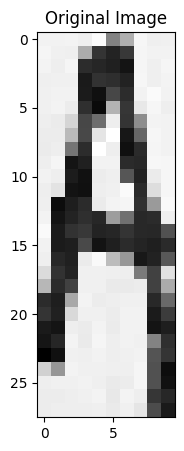

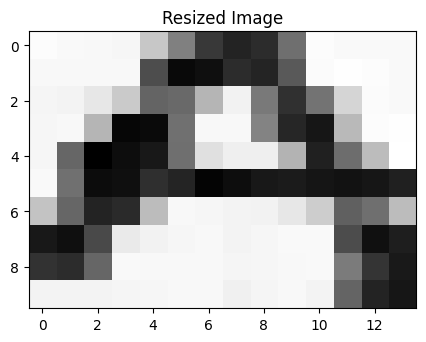

The predicted character is: A


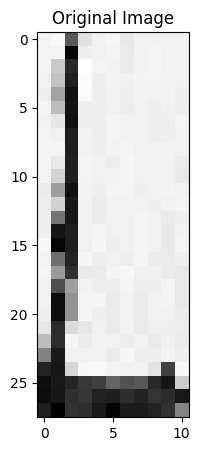

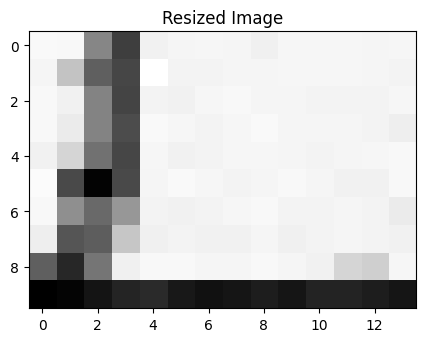

The predicted character is: L


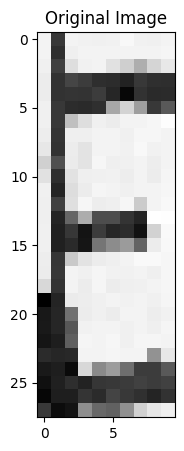

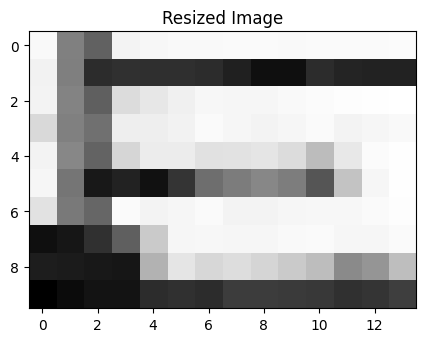

The predicted character is: E


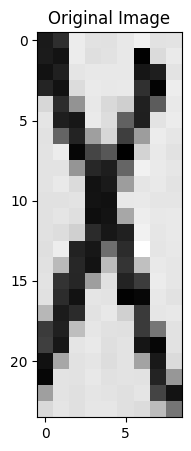

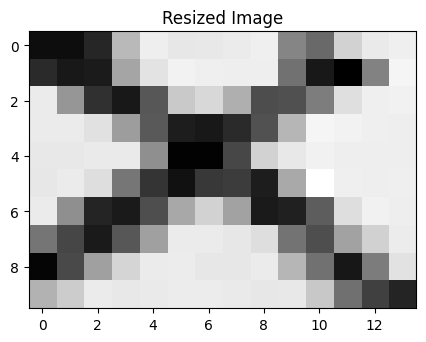

The predicted character is: X
The predicted name is: ALEX


In [58]:
import cv2
import torch
from torchvision import transforms

# Assuming the model is loaded and named `model`
# model = load_your_model_here()

def predict_character(image_path, model, char_map, img_size=(14, 10)):
    """
    Predicts the character of a given image.

    Parameters:
    - image_path: Path to the image file.
    - model: Pretrained model for prediction.
    - char_map: Dictionary mapping characters to indices and vice versa.
    - img_size: Size to which the image should be resized.

    Returns:
    - Predicted character as a string.
    """
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Display the original image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.show()

    # Resize the image
    img = cv2.resize(img, img_size)
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Resized Image')
    plt.show()
    # Normalize the image
    img = img / 255.0

    # Convert the image to a PyTorch tensor
    img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)  # Add batch dimension

    # Pass the image through the model
    with torch.no_grad():
        output = model(img_tensor)

    # Get the predicted index
    _, predicted_index = torch.max(output, 1)

    # Map the predicted index back to the character
    predicted_char = label_to_char[predicted_index.item()]

    return predicted_char

llista_imatges = ["imatge0.png","imatge1.png","imatge2.png","imatge3.png"]
name = []
for imatge in llista_imatges:
  image_path = imatge  # Replace with the actual path to your image
  predicted_char = predict_character(image_path, model, char_to_label, img_size=(14, 10))
  print(f"The predicted character is: {predicted_char}")
  name.append(predicted_char)

print(f"The predicted name is: {''.join(name)}")

image3.png


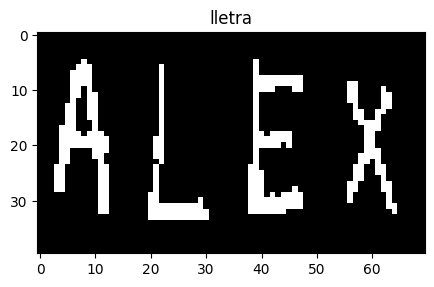

alex
4
imatge0.png
imatge1.png
imatge2.png
imatge3.png
True


In [51]:



def segmentar_imatge(imatge,nom,wdir):
    list_letters = [] #Crea una llista per guardar les lletres
    images = []
    trobat = False
    image_path = str(wdir+''+imatge)
    print(image_path)
    # Leer la imagen y convertirla a escala de grises
    img = cv2.imread(image_path)
    img = cv2.resize(img, (70,40))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicar umbral para binarizar la imagen
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.figure(figsize=(5, 5))
    plt.imshow(thresh, cmap='gray')
    plt.title('lletra')
    plt.show()
    # Encontrar los contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ordenar los contornos de izquierda a derecha
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    print(nom)
    print(len(contours))
    if len(contours) == len(nom):#si la quantitat de lletres correspo
    # print(nom)
        trobat = True
    # Iterar sobre los contornos y guardar cada letra como una imagen separada
        for i,lletra in enumerate(nom):
            list_letters.append(nom[i])
        for i, contour in enumerate(contours):
            # Obtener el bounding box del contorno
            x, y, w, h = cv2.boundingRect(contour)

            # Extraer la letra
            letter = img[y:y+h, x:x+w]
            images.append(letter)
            outdir = str("imatge"+str(i)+".png")
            print(outdir)
            cv2.imwrite(outdir, letter)
    return(images,list_letters,trobat)

imatge = "image3.png"
nom = "alex"
wdir = ""
print(segmentar_imatge(imatge,nom,wdir)[2])